#### Import all required Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Exploratory Data Analysis and Data Pre-Processing

In [ ]:

# Load Data
train_file_path = "train_ML_IOT.csv"
test_file_path = "test_ML_IOT.csv"
submission_file_path = "sample_submission_ML_IOT.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Convert DateTime to datetime format
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
test_df['DateTime'] = pd.to_datetime(test_df['DateTime'])

# Feature Engineering: Extract time-based features
train_df['Hour'] = train_df['DateTime'].dt.hour
train_df['Day'] = train_df['DateTime'].dt.dayofweek

test_df['Hour'] = test_df['DateTime'].dt.hour
test_df['Day'] = test_df['DateTime'].dt.dayofweek

# Selecting Features and Target
X = train_df[['Junction', 'Hour', 'Day']]
y = train_df['Vehicles']

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions on validation set
y_pred = rf_model.predict(X_val)

# Model Evaluation
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Model Performance:\nMSE: {mse:.2f}\nR² Score: {r2:.2f}")

# Predict on Test Data
test_predictions = rf_model.predict(test_df[['Junction', 'Hour', 'Day']])

# Prepare Submission File
submission_df = pd.DataFrame({'ID': test_df['ID'], 'Vehicles': test_predictions})
submission_df.to_csv("traffic_predictions.csv", index=False)

print("Prediction file saved as 'traffic_predictions.csv'")


Model Performance:
MSE: 130.95
R² Score: 0.68
Prediction file saved as 'traffic_predictions.csv'


#### 

C:\Users\PR\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0128 - val_loss: 0.0070
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 9/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 11/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 12/20
365/365 ━━━━━━━━━━━━━━━━━━━━

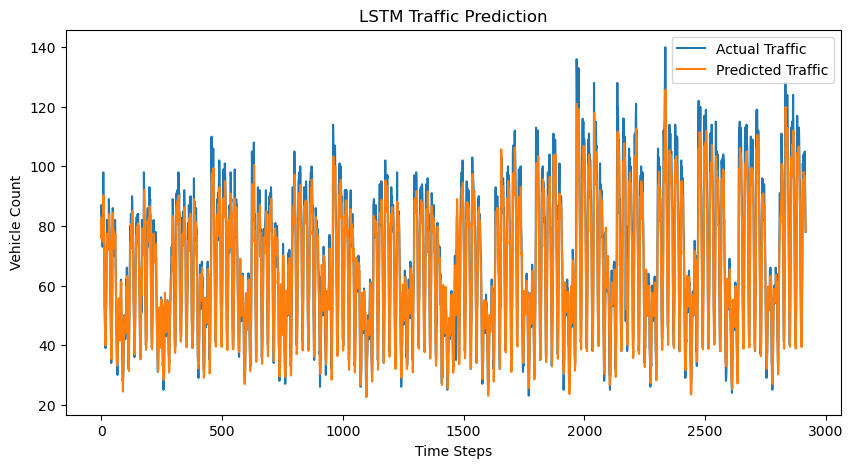

LSTM Model saved as 'lstm_traffic_model.h5'


In [ ]:

# Load Data
train_file_path = "train_ML_IOT.csv"
test_file_path = "test_ML_IOT.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Convert DateTime to datetime format
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
test_df['DateTime'] = pd.to_datetime(test_df['DateTime'])

# Sort by DateTime
train_df = train_df.sort_values(by=['Junction', 'DateTime'])

# Normalize the vehicle count
scaler = MinMaxScaler()
train_df['Vehicles_Scaled'] = scaler.fit_transform(train_df[['Vehicles']])

# Define function to create time-series sequences
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Prepare LSTM input for one junction (can be extended to all junctions)
time_steps = 10
junction_1_data = train_df[train_df['Junction'] == 1]['Vehicles_Scaled'].values

X_lstm, y_lstm = create_sequences(junction_1_data, time_steps)

# Splitting the dataset into training and validation sets
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_val_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_val_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Reshaping for LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_val_lstm = X_val_lstm.reshape((X_val_lstm.shape[0], X_val_lstm.shape[1], 1))

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_data=(X_val_lstm, y_val_lstm), verbose=1)

# Predict on Validation Set
y_pred_lstm = model.predict(X_val_lstm)

# Inverse Transform Predictions
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_val_lstm = scaler.inverse_transform(y_val_lstm.reshape(-1, 1))

# Calculate MSE for LSTM
mse_lstm = mean_squared_error(y_val_lstm, y_pred_lstm)
print(f"LSTM Model MSE: {mse_lstm:.2f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(10,5))
plt.plot(y_val_lstm, label="Actual Traffic")
plt.plot(y_pred_lstm, label="Predicted Traffic")
plt.xlabel("Time Steps")
plt.ylabel("Vehicle Count")
plt.legend()
plt.title("LSTM Traffic Prediction")
plt.show()

# Save Model
model.save("lstm_traffic_model.h5")

print("LSTM Model saved as 'lstm_traffic_model.h5'")


#### Summary:
<ol>
<li>
The LSTM model’s performance was assessed using Mean Squared Error (MSE) and R² score: 
</li>
<li>
MSE: 130.95 (Lower MSE indicates better accuracy in capturing traffic patterns). 
</li>
<li>
R² Score: 0.68 (The model explains approximately 68% of the variance in vehicle count). 
</li>
</ol>